In [197]:
%matplotlib inline

import os

import torch
import gpytorch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from MDAnalysis.analysis.rms import rmsd
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split

from mobius import ForceField, VirtualTarget

# Read MHC-I dataset

In [60]:
data = []
temperature = 300.
RT = 0.001987 * temperature

with open('binding_data_2013/bdata.20130222.mhci.txt') as f:
    lines = f.readlines()
    
    for line in lines[1:]:
        sline = line.split()
        data.append((sline[0], sline[1], int(sline[2]), sline[3], sline[4], float(sline[5])))

columns = ['species', 'mhc_allele', 'length', 'sequence', 'inequality', 'affinity_binding']
mhci = pd.DataFrame(data=data, columns=columns)

# Convert affinity binding (nM) in energy interaction (kcal/mol)
mhci['energy'] = RT * np.log(mhci['affinity_binding'] * 1e-9)

mhci.to_csv('binding_data_2013/bdata.20130222.mhci.csv', index=False)

In [61]:
mhci = pd.read_csv('binding_data_2013/bdata.20130222.mhci.csv')

In [5]:
for name, group in mhci[mhci['species'] == 'human'].groupby('mhc_allele'):
    print(name, len(group))

HLA-A*01:01 4792
HLA-A*02:01 12160
HLA-A*02:02 4155
HLA-A*02:03 6303
HLA-A*02:04 4
HLA-A*02:05 75
HLA-A*02:06 5628
HLA-A*02:07 80
HLA-A*02:10 18
HLA-A*02:11 1085
HLA-A*02:12 1183
HLA-A*02:16 921
HLA-A*02:17 346
HLA-A*02:19 1246
HLA-A*02:50 135
HLA-A*03:01 7358
HLA-A*03:02 26
HLA-A*03:19 30
HLA-A*11:01 6399
HLA-A*11:02 14
HLA-A*23:01 2641
HLA-A*24:02 3280
HLA-A*24:03 1381
HLA-A*25:01 960
HLA-A*26:01 4535
HLA-A*26:02 643
HLA-A*26:03 537
HLA-A*29:02 2789
HLA-A*30:01 2925
HLA-A*30:02 2057
HLA-A*31:01 5713
HLA-A*32:01 1136
HLA-A*32:07 88
HLA-A*32:15 74
HLA-A*33:01 3597
HLA-A*66:01 219
HLA-A*68:01 3795
HLA-A*68:02 5545
HLA-A*68:23 82
HLA-A*69:01 2565
HLA-A*74:01 15
HLA-A*80:01 1171
HLA-A1 1
HLA-A11 74
HLA-A2 63
HLA-A24 2
HLA-A26 4
HLA-A3 6
HLA-A3/11 2
HLA-B*07:02 4642
HLA-B*08:01 3538
HLA-B*08:02 1020
HLA-B*08:03 470
HLA-B*14:01 42
HLA-B*14:02 341
HLA-B*15:01 4448
HLA-B*15:02 164
HLA-B*15:03 701
HLA-B*15:09 832
HLA-B*15:17 1447
HLA-B*15:42 364
HLA-B*18:01 2832
HLA-B*27:01 4
HLA-B*27:02 8
HLA

# HLA-A*02:01

## Exploration

(7.0, 15.0)

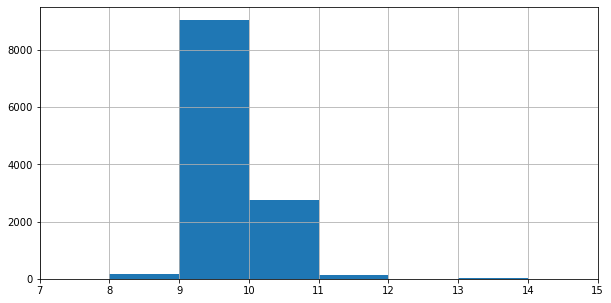

In [25]:
fig, ax = plt.subplots(figsize=(10, 5))
mhci[mhci['mhc_allele'] == 'HLA-A*02:01']['length'].hist(ax=ax, bins=range(7, 15))
ax.set_xlim([7, 15])

(0.0, 200.0)

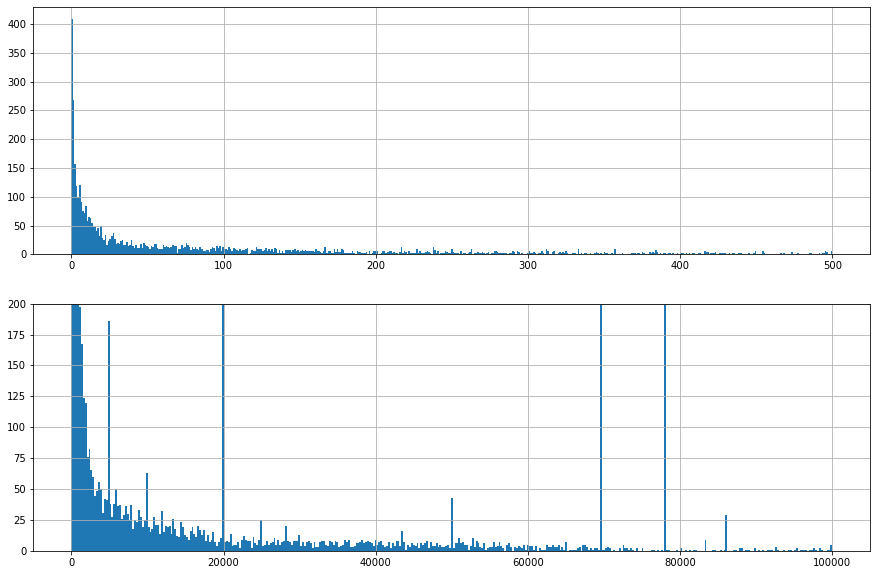

In [26]:
fig, axarr = plt.subplots(2, 1, figsize=(15, 10))
mhci[mhci['mhc_allele'] == 'HLA-A*02:01']['affinity_binding'].hist(ax=axarr[0], bins=np.linspace(0, 500, 500))
mhci[mhci['mhc_allele'] == 'HLA-A*02:01']['affinity_binding'].hist(ax=axarr[1], bins=np.linspace(0, 100000, 400))
axarr[1].set_ylim((0, 200))

<AxesSubplot:>

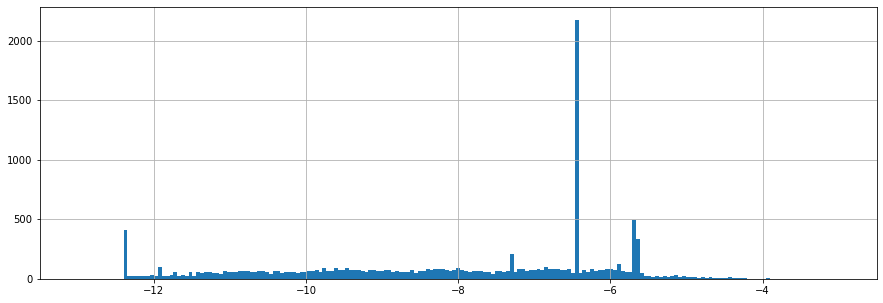

In [72]:
fig, ax = plt.subplots(figsize=(15, 5))
mhci[mhci['mhc_allele'] == 'HLA-A*02:01']['energy'].hist(ax=ax, bins=np.linspace(-13, -3, 200))

## Training

In [189]:
def transform(sequences, scale):    
    transformed = []
    
    for seq in sequences:
        tmp = []

        for aa in seq:
            tmp.extend(scale[scale['AA1'] == aa].values[0][2:])

        transformed.append(tmp)
        
    return torch.from_numpy(np.array(transformed)).float()


class SequenceKernel(gpytorch.kernels.Kernel):
    # the sequence kernel is stationary
    is_stationary = True     

    # this is the kernel function
    def forward(self, x1, x2, **params):
        # calculate the euclidean distance between inputs
        diff = self.covar_dist(x1, x2, **params)
        # prevent divide by 0 errors
        diff.where(diff == 0, torch.as_tensor(1e-20))
        # return diff
        return diff

    
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        #self.covar_module = SequenceKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [217]:
# Wrap training, prediction and plotting from the ExactGP-Tutorial into a function,
# so that we do not have to repeat the code later on
def train(model, likelihood, train_x, train_y, training_iter=training_iter):
    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        
        print('Iter %02d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.item(),
            model.likelihood.noise.item()
        ))
        
        optimizer.step()
        

def predict(model, likelihood, test_x):
    model.eval()
    likelihood.eval()
    
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        # Test points are regularly spaced along [0,1]
        return likelihood(model(test_x))


def plot(y_test, observed_pred):
    with torch.no_grad():
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        
        ax.scatter(y_test, observed_pred)
        
        ax.set_ylim([np.min([y_test, observed_pred]) - 1, np.max([y_test, observed_pred]) + 1])
        ax.set_xlabel('Experimental values (kcal/mol)', fontsize=20)
        ax.set_ylabel('Predicted values (kcal/mol)', fontsize=20)

In [205]:
# Split dataset in training and testing sets
selected = mhci[(mhci['mhc_allele'] == 'HLA-A*02:01') & (mhci['length'] == 9)]
X_train, X_test, y_train, y_test = train_test_split(selected['sequence'], selected['energy'], test_size=0.3)

In [206]:
# Transform sequence into tensor using amino acid scales
# ISA-ECI, z-scale, extended z-scale, DDPS from Zhou 2010 (10.1007/s00726-008-0228-1)
# extended DPPS from Zhou 2008 (10.1002/bip.21091)
extended_z_scale = pd.read_csv('extended_z_scale.csv')

X_train_transformed = transform(X_train, extended_z_scale)
X_test_transformed = transform(X_test, extended_z_scale)

y_train = torch.from_numpy(y_train.values).float()
y_test = torch.from_numpy(y_test.values).float()

In [207]:
# Initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_train_transformed, y_train, likelihood)

# Train GP model
train(model, likelihood, X_train_transformed, y_train, training_iter=1000)

/home/eberhardt/Applications/miniconda3/envs/mm/lib/python3.9/site-packages/gpytorch/utils/linear_cg.py:234: UserWarning: An output with one or more elements was resized since it had shape [11], which does not match the required output shape [1, 11].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:23.)
  torch.sum(mul_storage, -2, keepdim=True, out=alpha)


Iter 01/1000 - Loss: 25.888   lengthscale: 0.693   noise: 0.693
Iter 02/1000 - Loss: 23.674   lengthscale: 0.744   noise: 0.744
Iter 03/1000 - Loss: 21.698   lengthscale: 0.798   noise: 0.798
Iter 04/1000 - Loss: 19.937   lengthscale: 0.855   noise: 0.853
Iter 05/1000 - Loss: 18.369   lengthscale: 0.914   noise: 0.911
Iter 06/1000 - Loss: 16.973   lengthscale: 0.975   noise: 0.969
Iter 07/1000 - Loss: 15.730   lengthscale: 1.039   noise: 1.029
Iter 08/1000 - Loss: 14.623   lengthscale: 1.106   noise: 1.090
Iter 09/1000 - Loss: 13.636   lengthscale: 1.175   noise: 1.151
Iter 10/1000 - Loss: 12.755   lengthscale: 1.247   noise: 1.212
Iter 11/1000 - Loss: 11.967   lengthscale: 1.320   noise: 1.273
Iter 12/1000 - Loss: 11.262   lengthscale: 1.396   noise: 1.334
Iter 13/1000 - Loss: 10.629   lengthscale: 1.473   noise: 1.395
Iter 14/1000 - Loss: 10.060   lengthscale: 1.553   noise: 1.455
Iter 15/1000 - Loss: 9.547   lengthscale: 1.634   noise: 1.513
Iter 16/1000 - Loss: 9.084   lengthscale:

Iter 131/1000 - Loss: 1.876   lengthscale: 7.137   noise: 2.445
Iter 132/1000 - Loss: 1.875   lengthscale: 7.149   noise: 2.441
Iter 133/1000 - Loss: 1.879   lengthscale: 7.160   noise: 2.438
Iter 134/1000 - Loss: 1.877   lengthscale: 7.171   noise: 2.434
Iter 135/1000 - Loss: 1.876   lengthscale: 7.182   noise: 2.430
Iter 136/1000 - Loss: 1.873   lengthscale: 7.193   noise: 2.427
Iter 137/1000 - Loss: 1.874   lengthscale: 7.204   noise: 2.423
Iter 138/1000 - Loss: 1.873   lengthscale: 7.215   noise: 2.419
Iter 139/1000 - Loss: 1.872   lengthscale: 7.226   noise: 2.416
Iter 140/1000 - Loss: 1.872   lengthscale: 7.237   noise: 2.412
Iter 141/1000 - Loss: 1.870   lengthscale: 7.248   noise: 2.408
Iter 142/1000 - Loss: 1.869   lengthscale: 7.259   noise: 2.404
Iter 143/1000 - Loss: 1.867   lengthscale: 7.270   noise: 2.401
Iter 144/1000 - Loss: 1.869   lengthscale: 7.281   noise: 2.397
Iter 145/1000 - Loss: 1.870   lengthscale: 7.292   noise: 2.393
Iter 146/1000 - Loss: 1.869   lengthscal

Iter 260/1000 - Loss: 1.784   lengthscale: 8.405   noise: 1.885
Iter 261/1000 - Loss: 1.785   lengthscale: 8.414   noise: 1.881
Iter 262/1000 - Loss: 1.782   lengthscale: 8.422   noise: 1.876
Iter 263/1000 - Loss: 1.781   lengthscale: 8.431   noise: 1.871
Iter 264/1000 - Loss: 1.779   lengthscale: 8.439   noise: 1.867
Iter 265/1000 - Loss: 1.780   lengthscale: 8.447   noise: 1.862
Iter 266/1000 - Loss: 1.782   lengthscale: 8.455   noise: 1.857
Iter 267/1000 - Loss: 1.780   lengthscale: 8.464   noise: 1.853
Iter 268/1000 - Loss: 1.779   lengthscale: 8.472   noise: 1.848
Iter 269/1000 - Loss: 1.781   lengthscale: 8.480   noise: 1.843
Iter 270/1000 - Loss: 1.777   lengthscale: 8.488   noise: 1.839
Iter 271/1000 - Loss: 1.777   lengthscale: 8.497   noise: 1.834
Iter 272/1000 - Loss: 1.776   lengthscale: 8.505   noise: 1.829
Iter 273/1000 - Loss: 1.775   lengthscale: 8.513   noise: 1.825
Iter 274/1000 - Loss: 1.777   lengthscale: 8.521   noise: 1.820
Iter 275/1000 - Loss: 1.774   lengthscal

Iter 389/1000 - Loss: 1.735   lengthscale: 9.279   noise: 1.368
Iter 390/1000 - Loss: 1.732   lengthscale: 9.284   noise: 1.365
Iter 391/1000 - Loss: 1.733   lengthscale: 9.289   noise: 1.362
Iter 392/1000 - Loss: 1.733   lengthscale: 9.294   noise: 1.360
Iter 393/1000 - Loss: 1.732   lengthscale: 9.299   noise: 1.357
Iter 394/1000 - Loss: 1.731   lengthscale: 9.304   noise: 1.354
Iter 395/1000 - Loss: 1.733   lengthscale: 9.309   noise: 1.351
Iter 396/1000 - Loss: 1.732   lengthscale: 9.313   noise: 1.349
Iter 397/1000 - Loss: 1.731   lengthscale: 9.318   noise: 1.346
Iter 398/1000 - Loss: 1.731   lengthscale: 9.323   noise: 1.343
Iter 399/1000 - Loss: 1.728   lengthscale: 9.328   noise: 1.341
Iter 400/1000 - Loss: 1.731   lengthscale: 9.332   noise: 1.338
Iter 401/1000 - Loss: 1.729   lengthscale: 9.337   noise: 1.335
Iter 402/1000 - Loss: 1.732   lengthscale: 9.342   noise: 1.333
Iter 403/1000 - Loss: 1.727   lengthscale: 9.346   noise: 1.330
Iter 404/1000 - Loss: 1.729   lengthscal

Iter 518/1000 - Loss: 1.719   lengthscale: 9.722   noise: 1.160
Iter 519/1000 - Loss: 1.722   lengthscale: 9.724   noise: 1.159
Iter 520/1000 - Loss: 1.718   lengthscale: 9.726   noise: 1.159
Iter 521/1000 - Loss: 1.722   lengthscale: 9.728   noise: 1.158
Iter 522/1000 - Loss: 1.722   lengthscale: 9.730   noise: 1.157
Iter 523/1000 - Loss: 1.722   lengthscale: 9.733   noise: 1.157
Iter 524/1000 - Loss: 1.720   lengthscale: 9.735   noise: 1.156
Iter 525/1000 - Loss: 1.724   lengthscale: 9.737   noise: 1.156
Iter 526/1000 - Loss: 1.721   lengthscale: 9.739   noise: 1.155
Iter 527/1000 - Loss: 1.723   lengthscale: 9.741   noise: 1.154
Iter 528/1000 - Loss: 1.717   lengthscale: 9.743   noise: 1.154
Iter 529/1000 - Loss: 1.722   lengthscale: 9.745   noise: 1.153
Iter 530/1000 - Loss: 1.723   lengthscale: 9.747   noise: 1.153
Iter 531/1000 - Loss: 1.721   lengthscale: 9.749   noise: 1.152
Iter 532/1000 - Loss: 1.721   lengthscale: 9.752   noise: 1.152
Iter 533/1000 - Loss: 1.721   lengthscal

Iter 647/1000 - Loss: 1.720   lengthscale: 9.931   noise: 1.132
Iter 648/1000 - Loss: 1.719   lengthscale: 9.932   noise: 1.132
Iter 649/1000 - Loss: 1.717   lengthscale: 9.934   noise: 1.132
Iter 650/1000 - Loss: 1.718   lengthscale: 9.935   noise: 1.132
Iter 651/1000 - Loss: 1.717   lengthscale: 9.936   noise: 1.132
Iter 652/1000 - Loss: 1.718   lengthscale: 9.938   noise: 1.132
Iter 653/1000 - Loss: 1.719   lengthscale: 9.939   noise: 1.131
Iter 654/1000 - Loss: 1.724   lengthscale: 9.941   noise: 1.131
Iter 655/1000 - Loss: 1.717   lengthscale: 9.942   noise: 1.131
Iter 656/1000 - Loss: 1.721   lengthscale: 9.943   noise: 1.131
Iter 657/1000 - Loss: 1.719   lengthscale: 9.945   noise: 1.131
Iter 658/1000 - Loss: 1.720   lengthscale: 9.946   noise: 1.131
Iter 659/1000 - Loss: 1.719   lengthscale: 9.947   noise: 1.131
Iter 660/1000 - Loss: 1.721   lengthscale: 9.949   noise: 1.131
Iter 661/1000 - Loss: 1.720   lengthscale: 9.950   noise: 1.131
Iter 662/1000 - Loss: 1.718   lengthscal

Iter 774/1000 - Loss: 1.718   lengthscale: 10.077   noise: 1.132
Iter 775/1000 - Loss: 1.719   lengthscale: 10.078   noise: 1.132
Iter 776/1000 - Loss: 1.717   lengthscale: 10.079   noise: 1.132
Iter 777/1000 - Loss: 1.719   lengthscale: 10.081   noise: 1.132
Iter 778/1000 - Loss: 1.716   lengthscale: 10.082   noise: 1.132
Iter 779/1000 - Loss: 1.719   lengthscale: 10.083   noise: 1.132
Iter 780/1000 - Loss: 1.717   lengthscale: 10.084   noise: 1.132
Iter 781/1000 - Loss: 1.717   lengthscale: 10.085   noise: 1.132
Iter 782/1000 - Loss: 1.717   lengthscale: 10.086   noise: 1.132
Iter 783/1000 - Loss: 1.719   lengthscale: 10.087   noise: 1.132
Iter 784/1000 - Loss: 1.720   lengthscale: 10.088   noise: 1.132
Iter 785/1000 - Loss: 1.718   lengthscale: 10.089   noise: 1.132
Iter 786/1000 - Loss: 1.719   lengthscale: 10.090   noise: 1.131
Iter 787/1000 - Loss: 1.719   lengthscale: 10.091   noise: 1.131
Iter 788/1000 - Loss: 1.721   lengthscale: 10.092   noise: 1.131
Iter 789/1000 - Loss: 1.7

Iter 901/1000 - Loss: 1.718   lengthscale: 10.198   noise: 1.133
Iter 902/1000 - Loss: 1.716   lengthscale: 10.199   noise: 1.133
Iter 903/1000 - Loss: 1.717   lengthscale: 10.200   noise: 1.133
Iter 904/1000 - Loss: 1.715   lengthscale: 10.201   noise: 1.133
Iter 905/1000 - Loss: 1.719   lengthscale: 10.201   noise: 1.133
Iter 906/1000 - Loss: 1.714   lengthscale: 10.202   noise: 1.133
Iter 907/1000 - Loss: 1.718   lengthscale: 10.203   noise: 1.133
Iter 908/1000 - Loss: 1.717   lengthscale: 10.204   noise: 1.132
Iter 909/1000 - Loss: 1.717   lengthscale: 10.205   noise: 1.132
Iter 910/1000 - Loss: 1.717   lengthscale: 10.205   noise: 1.132
Iter 911/1000 - Loss: 1.714   lengthscale: 10.206   noise: 1.132
Iter 912/1000 - Loss: 1.719   lengthscale: 10.207   noise: 1.132
Iter 913/1000 - Loss: 1.718   lengthscale: 10.208   noise: 1.132
Iter 914/1000 - Loss: 1.714   lengthscale: 10.209   noise: 1.132
Iter 915/1000 - Loss: 1.719   lengthscale: 10.210   noise: 1.132
Iter 916/1000 - Loss: 1.7

R2   : 0.667
RMSD : 1.220


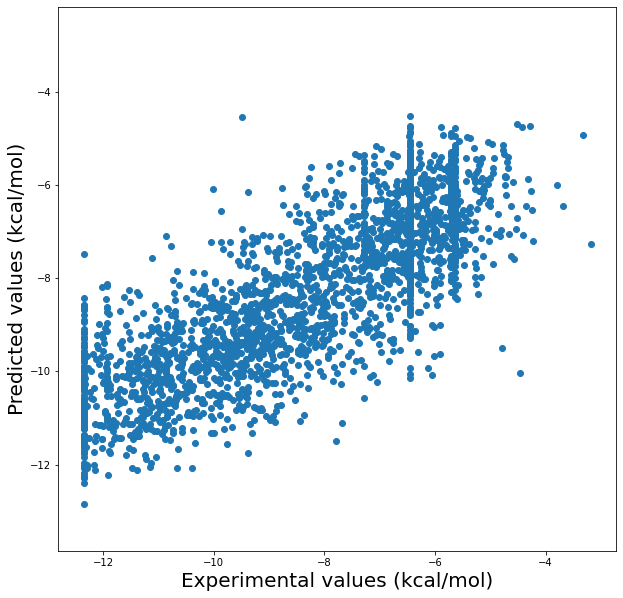

In [218]:
# Predict energy for test set
observed_pred = predict(model, likelihood, X_test_transformed)

print('R2   : %.3f' % pearsonr(y_test, observed_pred.mean.numpy())[0]**2)
print('RMSD : %.3f' % rmsd(y_test, observed_pred.mean.numpy()))

# Plot results
plot(y_test.numpy(), observed_pred.mean.numpy())